# Training CNN model for tree classification based on images of their bark
In this notebook a CNN model will be developed to classify bark according to tree species. The CNN will be trained to classify the original images. After the training the CNN will be evaluated with some post-hoc model analysis methods like LIME and SHAP.

## Organizing the data structure (only done once, after downloading the dataset)
First, the dataset (https://www.kaggle.com/datasets/saurabhshahane/barkvn50) should be downloaded to directory: "./data/BarkVN-50/" and unzipped. You should then have the following structure:
- data
    - BarkVN-50
        - BarkVN-50_mendeley
            - Acacia
            - Adenanthera microsperma
            - Adenieum species
            - Anacardium occidentale
            - ...

Since this is not ideal for this CNN, a subset of the data (with at least 109 samples and image size 404*303, resulting in 10 species) is selected and split into training data using the code in the next cell. After the execution you should have another two directories under "./data/BarkVN-50/" - a Test and a Train directory. Each Train species subdirectory will contain directories with 99 samples of the species' bark. The Test subdirectory will contain 10.

The tree species that you can expect will be copied to the Train and Test subdirectories are: Cocos nucifera (0), Dipterocarpus alatus (1), Eucalyptus (2), Ficus microcarpa (3), Hevea brasiliensis (4), Musa (5), Psidium guajava (6), Syzygium nervosum (7), Terminalia catappa (8), Veitchia merrilli (9).

Note 1: this cell only needs to be executed once (this is why it is commented out by default).

Note 2: the directory "./data/BarkVN-50/BarkVN-50_mendeley" may be deleted after this step.

In [ ]:
# import helpers.split

# helpers.split.train_test_split()

## Loading the Dataset and creating DataLoaders
Since the used dataset is a custom one, we need to first create a custom Dataset for loading, transforming and delivering datapoints. Since the amount of training images (99 per class, 10 classes) is quite low, the training dataset additionally receives a ```tranforms``` object that randomly applies image transformations, thus artificially increasing the data pool as well as training the image to be more robust [1], if for example a horizontally flipped or a slightly rotated picture is given. These were chosen due to the easy of accessibility with the module ```torchvision.transforms.v2```.

In [1]:
from helpers.dataset import BarkVN50Dataset
from torch.utils.data import DataLoader
from torch import device, manual_seed
from torch.cuda import is_available
from torchvision.transforms.v2 import Compose, RandomVerticalFlip, RandomHorizontalFlip, RandomRotation

# setting random seed
manual_seed(0)

# recognizing device
DEVICE = device("cuda" if is_available() else "cpu")

# load train dataset and create DataLoaders that automatically create minibatches and shuffle the data
transforms = Compose([RandomVerticalFlip(p=0.5), RandomHorizontalFlip(p=0.5), RandomRotation(30)])
train_dataset = BarkVN50Dataset(train=True, device=DEVICE, transforms=transforms)
test_dataset = BarkVN50Dataset(train=False, device=DEVICE, transforms=None)

train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False)

## Training the CNN model
To train the model we can use either the Train/Test split or the K-Fold Cross Validation split. In my case I first split the dataset into a Train and Test Subset and will mostly be training the model with KF CV. This has the advantage that I will always have a dataset I can use to assess all of the models separately and also see how much the model's performance depends on a lucky/unlucky dataset split.

### Training a CNN model with Train/Test Split
This chapter will show how to train a single model (either a wholly new one or a pre-trained one) using the Train/Test split.

In [ ]:
from helpers.cnn import ConvolutionalNeuralNetwork
from torch.optim import Adam
# from torch.optim import SGD

# Initialization of the CNN model
model = ConvolutionalNeuralNetwork().to(device=DEVICE)

# Optimizer: either Adam or SGD may be used to optimize the model's weights during training
optimizer = Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
# optimizer = SGD(model.parameters(), lr=3e-4, weight_decay=1e-4)

If an already existing model should be trained for more epochs, it can be loaded from disk:

In [ ]:
# from torch import load

# checkpoint = load("models/checkpoint-2024-11-04-18-14-59.tar", weights_only=True)
# model.load_state_dict(checkpoint["model_state_dict"])
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# epoch = checkpoint["epoch"]
# loss = checkpoint["loss"]

And once the model is initialized (and weights have also been loaded from disk), the model training can begin:

In [ ]:
from helpers.train import train_cnn
from torch.nn import CrossEntropyLoss

model.train()
num_epochs = 50
loss = train_cnn(
    num_epochs=num_epochs,
    model=model,
    criterion=CrossEntropyLoss(),
    dataloader=train_dataloader,
    optimizer=optimizer,
)

### Saving the model
If the model should be trained again later on, it can be saved using the .tar (PyTorch convention for model checkpoints) format:

In [ ]:
from torch import save
from datetime import datetime

time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# If the model should be trainable
save(
    {
        "epoch": num_epochs,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss,
    },
    f"models/checkpoint-{num_epochs}ep-{time}.tar",
)

And if it shouldn't be trainable, but nonetheless be evaluated, only the model's state_dictionary can be saved with the .pt format (PyTorch convention for trained, serialized models):

Note: .pt model files usually require less disk space that .tar model files

In [ ]:
from torch import save
from datetime import datetime

# If the model will only be used for inference (requires 2-3 times less storage than the other save option)
time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
save(model.state_dict(), f"models/eval-model-{num_epochs}ep-{time}.pt")

### Training k models using K-Fold Cross Validation
Another option would be to train the model using K-Fold Cross Validation. This has the advantage of evaluating the model more thoroughly by reducing the "lucky/unlucky split" problem.

In [ ]:
from helpers.kfold import train_cnn_kfold
from torch.nn import CrossEntropyLoss

train_cnn_kfold(
    epoch_per_kfold=5,
    num_kfold=10,
    train_dataset=train_dataset,
    test_loader=test_dataloader,
    sgd=True,
    criterion=CrossEntropyLoss(),
    learning_rate=3e-4,
    weight_decay=1e-4,
    device=DEVICE,
)

## Evaluating the model's accuracy on test data
Now that a CNN model has been trained it is time to evaluate it on original data, test data as well as data altered with noise and/or overlapping pixels. Using LIME and SHAP the CNN's classification and created heatmap changes will be evaluated.

To load a saved model for evaluation, the following commands can be used:

In [2]:
from torch import load
from helpers.cnn import ConvolutionalNeuralNetwork

model = ConvolutionalNeuralNetwork().to(device=DEVICE)
# model.load_state_dict(load("models/ignoring-0/eval-model-20ep-2024-11-15-20-38-07.pt", weights_only=True))
model.load_state_dict(
    load("results/model/checkpoint-50ep-2024-11-20-17-00-09.tar", weights_only=True)["model_state_dict"]
)
model.eval()

ConvolutionalNeuralNetwork(
  (cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=5, stride=5, padding=2, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=5, stride=5, padding=2, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3536, out_features=10, bias=True)
  )
)

To interpret the evaluation results better, we can first visualize the testing dataset:

In [ ]:
from helpers.functions import visualize_test_dataset

visualize_test_dataset(test_dataset=test_dataset, model=model)

Before evaluation with more complex algorithms, it is helpful to visualize the model's performance with a confusion matrix:

Number Of Images Tested 100,	Loss: 0.3097,	Accuracy: 89.0000
Number Of Images Tested 990,	Loss: 0.0597,	Accuracy: 97.8788


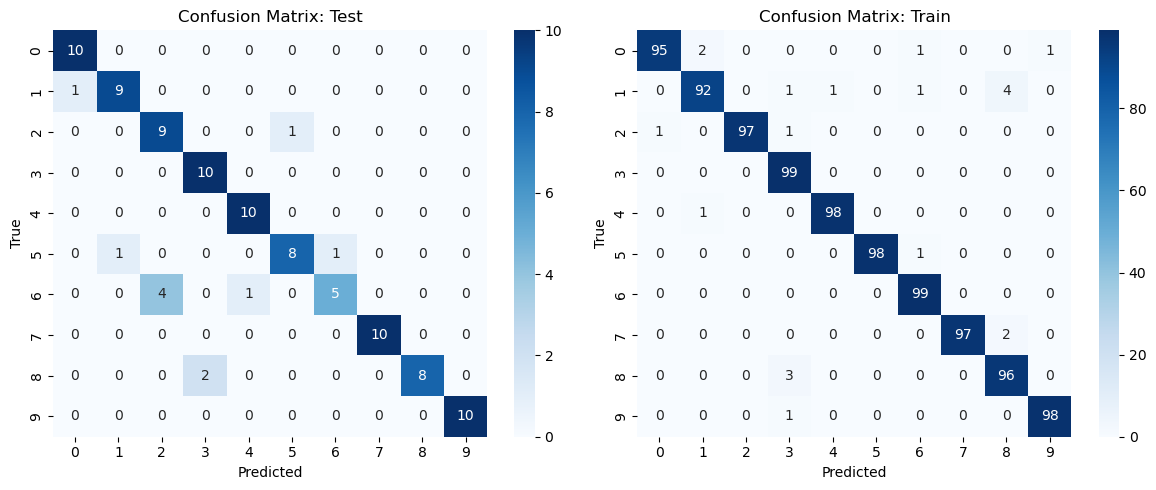

In [4]:
from helpers.evaluate import evaluate_cnn
from torch.nn import CrossEntropyLoss

evaluate_cnn(
    criterion=CrossEntropyLoss(),
    test_dataloader=test_dataloader,
    train_dataloader=train_dataloader,
    model=model,
)

### Model evaluation with SHAP and LIME
Now that we see how the trained CNN performs on training and (as opposed to it) on testing data, it is time to see *why* the CNN performs how it does. For this we will mainly use two algorithms/tools: SHAP and LIME.

The LIME (Local Interpretable Model-agnostic Explanations) method interprets model predictions based on locally approximating the model. It is simpler than SHAP dut to this local nature.

SHAP (SHapley Additive exPlanations) values are importance values for a specific prediction a model makes that are assigned to each feature of the analyzed input. In the field of cooperative game theory (mathematics), Shapley values 
Shapley values are 
[2, 3]

In [ ]:
from helpers.lime import lime_evaluate_cnn

lime_evaluate_cnn(model=model, test_dataset=test_dataset, device=DEVICE, augmented=True, test_image_index=0)

In [ ]:
from helpers.shap import shap_evaluate_cnn

# evaluates augmented images by default
shap_evaluate_cnn(model=model, test_dataset=test_dataset, train_dataset=train_dataset, test_image_index=1)

### Model evaluation with activation hooks
To further analyze the model's performance we can view its layers' activations after an image was passed through the model. The implemented hooks will record the data from a forward pass. This will be visualized by the plot_image_activations function.

The first image displays the input.

The second image shows the activations of the FC layer at the end of the model. It shows the model's prediction of how likely it is that the model belongs to each of the classes.

The third and fourth images plot the activations of the first and second convolutional layers.

In [ ]:
from helpers.activations import setup_hooks, plot_image_activations

activations = setup_hooks(model, {})
plot_image_activations(activations=activations, index=90, model=model, test_dataset=test_dataset)

To further analyze the layer activations of the model, we can generate a random image and run the model on it. Using the Adam optimizer the model will then be adjusted after each epoch to alter it in such a way that the selected layer's activation is maximized. This function will plot images that maximize the activation for different filters of the selected layer:

Filter:   0%|          | 0/8 [00:00<?, ?it/s]

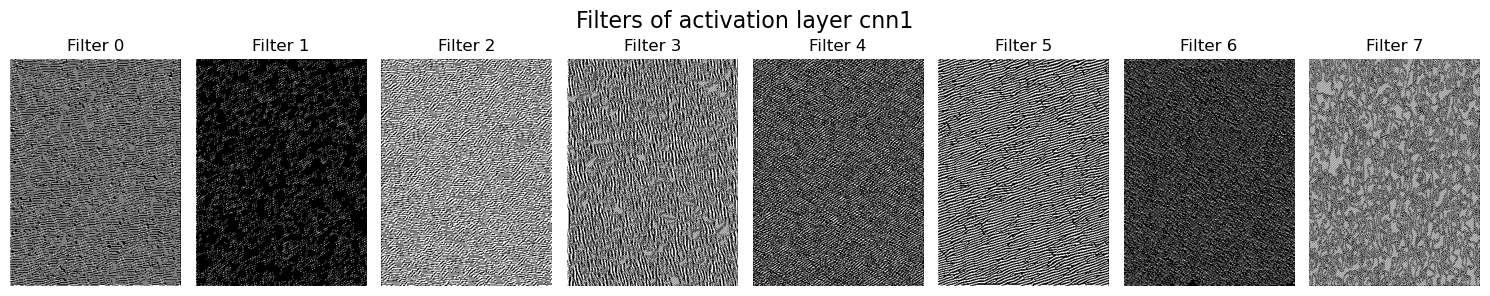

Filter:   0%|          | 0/16 [00:00<?, ?it/s]

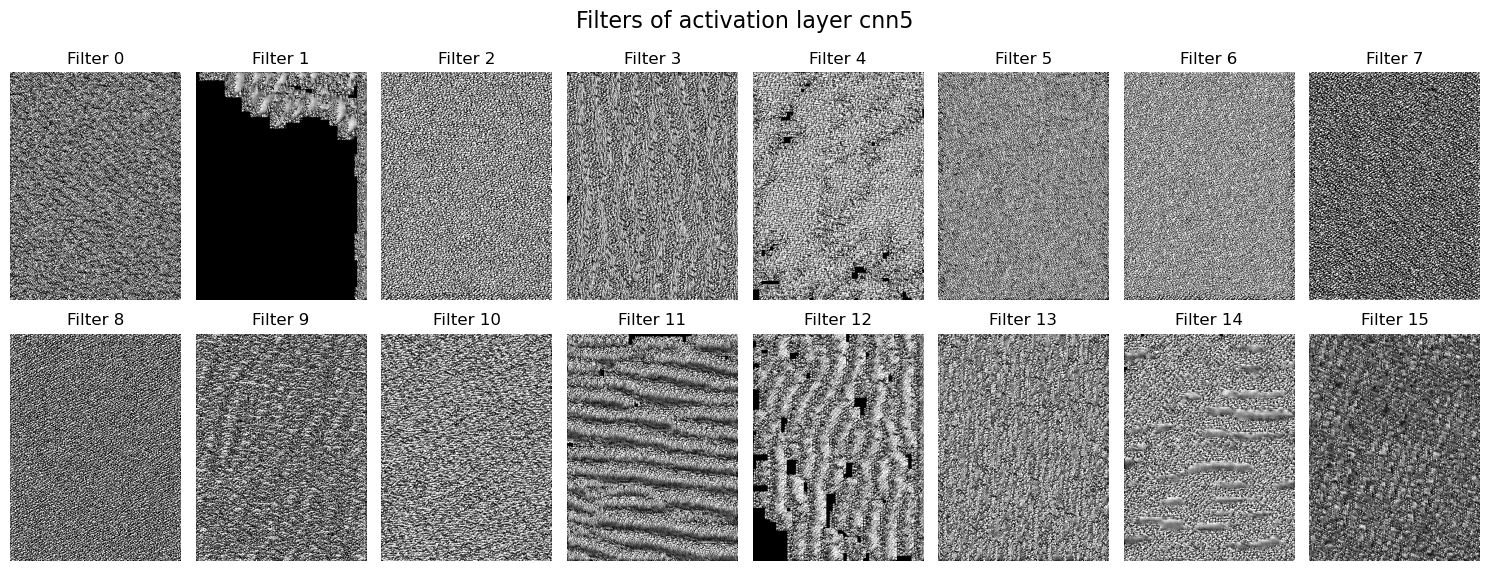

In [6]:
from helpers.activations import filter_activation_maximization

# Maximize activations for the first ReLU layer
filter_activation_maximization(cnn_layer_num=1, model=model, input_size=(1, 1, 404, 303), lr=0.1, iterations=100)

# Maximize activations for the second ReLU layer
filter_activation_maximization(cnn_layer_num=5, model=model, input_size=(1, 1, 404, 303), lr=0.1, iterations=400)

## Citations

[1] https://towardsdatascience.com/improves-cnn-performance-by-applying-data-transformation-bf86b3f4cef4

[2] https://proceedings.neurips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf

[3] https://www.markovml.com/blog/lime-vs-shap